<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QiskitAer_ExtendedStabilizerSimulator_mkbahk_20251222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip uninstall qiskit qiskit-aer qiskit-aer-gpu qiskit-ibm-runtime -y

Found existing installation: qiskit 2.2.3
Uninstalling qiskit-2.2.3:
  Successfully uninstalled qiskit-2.2.3
Found existing installation: qiskit-aer 0.17.1
Uninstalling qiskit-aer-0.17.1:
  Successfully uninstalled qiskit-aer-0.17.1
Found existing installation: qiskit-aer-gpu 0.15.1
Uninstalling qiskit-aer-gpu-0.15.1:
  Successfully uninstalled qiskit-aer-gpu-0.15.1
Found existing installation: qiskit-ibm-runtime 0.44.0
Uninstalling qiskit-ibm-runtime-0.44.0:
  Successfully uninstalled qiskit-ibm-runtime-0.44.0


In [1]:
!pip install qiskit[visualization]
!pip install qiskit-aer
#!pip install qiskit-aer-gpu==0.15.1
!pip install qiskit-ibm-runtime

  Using cached qiskit_aer-0.17.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
Using cached qiskit_aer-0.17.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
  Using cached qiskit_ibm_runtime-0.44.0-py3-none-any.whl.metadata (21 kB)
Using cached qiskit_ibm_runtime-0.44.0-py3-none-any.whl (1.5 MB)


In [3]:
%pip show qiskit
%pip show qiskit-aer
#%pip show qiskit-aer-gpu
%pip show qiskit-ibm-runtime

Name: qiskit
Version: 2.2.3
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: dill, numpy, rustworkx, scipy, stevedore, typing-extensions
Required-by: qiskit-aer, qiskit-ibm-runtime
Name: qiskit-aer
Version: 0.17.2
Summary: Aer - High performance simulators for Qiskit
Home-page: https://github.com/Qiskit/qiskit-aer
Author: AER Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, psutil, python-dateutil, qiskit, scipy
Required-by: 
Name: qiskit-ibm-runtime
Version: 0.44.0
Summary: IBM Quantum client for Qiskit Runtime.
Home-page: 
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/loc

In [19]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

import random


In [21]:
circ = QuantumCircuit(40, 40)

# Initialize with a Hadamard layer
circ.h(range(40))
# Apply some random CNOT and T gates
qubit_indices = [i for i in range(40)]

for i in range(10):
    control, target, t = random.sample(qubit_indices, 3)
    circ.cx(control, target)
    circ.t(t)
###for

circ.measure(range(40), range(40))

In [22]:
# Create statevector method simulator
statevector_simulator = AerSimulator(method='statevector')

# Transpile circuit for backend
tcirc = transpile(circ, statevector_simulator)

# Try and run circuit
statevector_result =  statevector_simulator.run(tcirc, shots=1).result()
print('This succeeded?: {}'.format(statevector_result.success))
print('Why not? {}'.format(statevector_result.status))

CircuitTooWideForTarget: 'Number of qubits (40) in circuit-57 is greater than maximum (29) in the coupling_map'

In [23]:
# Create extended stabilizer method simulator
extended_stabilizer_simulator = AerSimulator(method='extended_stabilizer')

# Transpile circuit for backend
tcirc = transpile(circ, extended_stabilizer_simulator)

extended_stabilizer_result = extended_stabilizer_simulator.run(tcirc, shots=1).result()
print('This succeeded?: {}'.format(extended_stabilizer_result.success))

This succeeded?: True


In [24]:
small_circ = QuantumCircuit(2, 2)
small_circ.h(0)
small_circ.cx(0, 1)
small_circ.t(0)
small_circ.measure([0, 1], [0, 1])
# This circuit should give 00 or 11 with equal probability...
expected_results ={'00': 50, '11': 50}


In [25]:
tsmall_circ = transpile(small_circ, extended_stabilizer_simulator)
result = extended_stabilizer_simulator.run(
    tsmall_circ, shots=100).result()
counts = result.get_counts(0)
print('100 shots in {}s'.format(result.time_taken))

100 shots in 0.0007605552673339844s


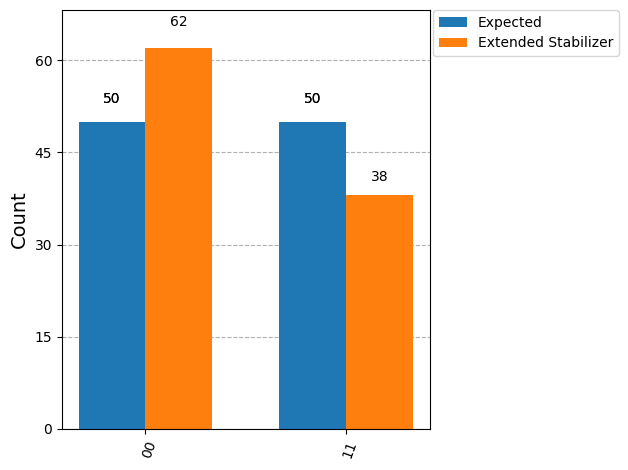

In [26]:
plot_histogram([expected_results, counts],
               legend=['Expected', 'Extended Stabilizer'])

100 shots in 0.0008535385131835938s


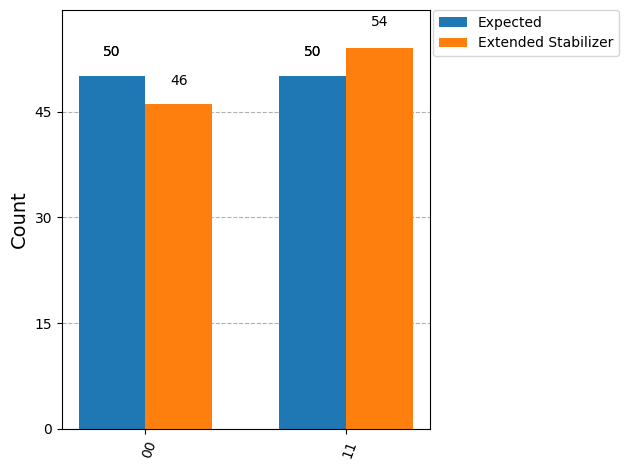

In [27]:
# Add runtime options for extended stabilizer simulator
opts = {'extended_stabilizer_approximation_error': 0.03}

reduced_error = extended_stabilizer_simulator.run(
    tsmall_circ, shots=100, **opts).result()

reduced_error_counts = reduced_error.get_counts(0)
print('100 shots in {}s'.format(reduced_error.time_taken))
plot_histogram([expected_results, reduced_error_counts],
               legend=['Expected', 'Extended Stabilizer'])

In [28]:
print("The circuit above, with 100 shots at precision 0.03 "
      "and default mixing time, needed {}s".format(int(reduced_error.time_taken)))

opts = {
    'extended_stabilizer_approximation_error': 0.03,
    'extended_stabilizer_mixing_time': 100
}

optimized = extended_stabilizer_simulator.run(
    tsmall_circ, shots=100, **opts).result()

print('Dialing down the mixing time, we completed in just {}s'.format(optimized.time_taken))



The circuit above, with 100 shots at precision 0.03 and default mixing time, needed 0s
Dialing down the mixing time, we completed in just 0.0008246898651123047s


In [29]:
# We set these options here only to make the example run more quickly.
opts = {'extended_stabilizer_mixing_time': 100}

multishot = extended_stabilizer_simulator.run(
    tcirc, shots=100, **opts).result()
print("100 shots took {} s".format(multishot.time_taken))

100 shots took 30.537553071975708 s


In [ ]:
opts = {
    'extended_stabilizer_measure_sampling': True,
    'extended_stabilizer_mixing_time': 100
}

measure_sampling = extended_stabilizer_simulator.run(
    circ, shots=100, **opts).result()
print("With the optimization, 100 shots took {} s".format(result.time_taken))
